PWV -> nscale: -0.63
zenith -> airmass: 1.85


(0.0, 100.0)

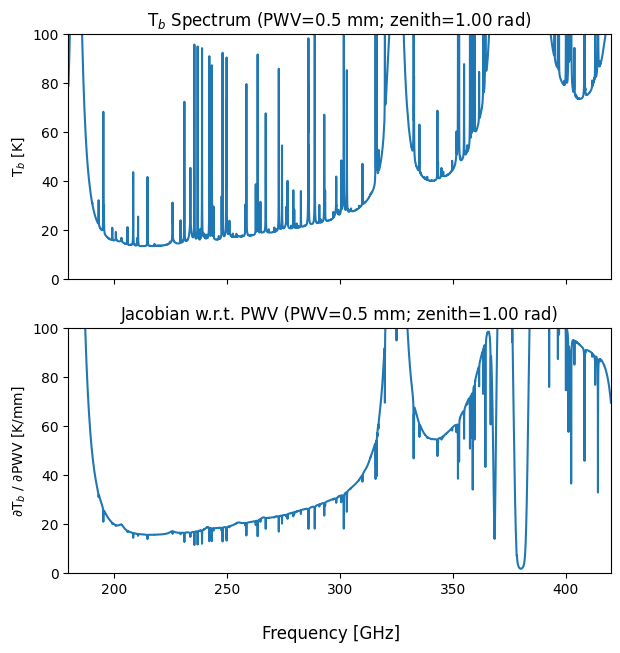

In [7]:
import numpy as np
import matplotlib.pyplot as plt

from src.ozone import Ozone

pwv = 0.5
zenith = 1

data_path = '/Users/namsonnguyen/repo/data/AM_Data/MaunaKea_SON50/Nscale21_AirMass11/'
my_ozone = Ozone(am_model_data_path=data_path)
spectrum, jacobian = my_ozone(pwv, zenith)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(7, 7), sharex=True, sharey=True)

freq_channels = np.linspace(180, 420, my_ozone.data['freq']['points'])
ax1.set_title(r"T$_b$ Spectrum" + f" (PWV={pwv} mm; zenith={zenith:.2f} rad)")
ax1.plot(freq_channels, spectrum[0,0])
ax1.set_ylabel(r'T$_b$ [K]')
ax1.set_xlim(min(freq_channels), max(freq_channels));

ax2.plot(freq_channels, jacobian)
ax2.set_title(f"Jacobian w.r.t. PWV (PWV={pwv} mm; zenith={zenith:.2f} rad)")
ax2.set_ylabel(r'$\partial$T$_b$ / $\partial$PWV [K/mm]')
fig.supxlabel('Frequency [GHz]')
ax2.set_xlim(min(freq_channels), max(freq_channels));
ax2.set_ylim(0, 100)

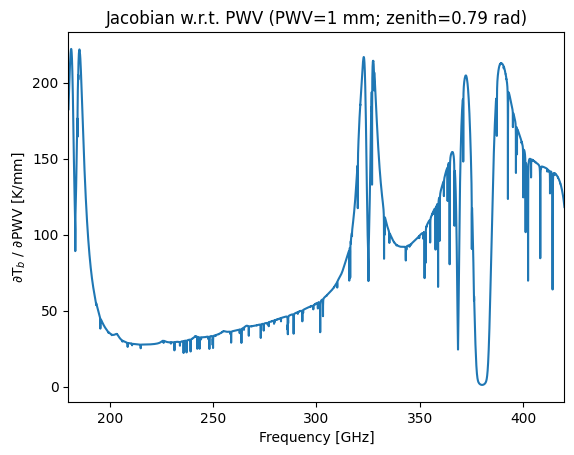

In [8]:
plt.plot(freq_channels, jacobian)
plt.title(f"Jacobian w.r.t. PWV (PWV={pwv} mm; zenith={zenith:.2f} rad)")
plt.ylabel(r'$\partial$T$_b$ / $\partial$PWV [K/mm]')
plt.xlabel('Frequency [GHz]')
plt.xlim(min(freq_channels), max(freq_channels));

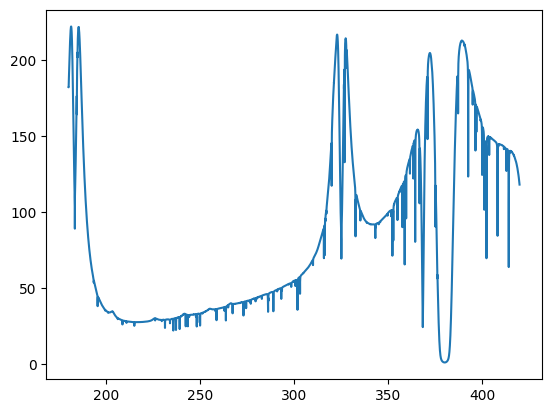

In [10]:
from scipy.interpolate import RegularGridInterpolator

interp_func = RegularGridInterpolator(
    points=(my_ozone.data['Nscale']['map'], my_ozone.data['airmass']['map'], my_ozone.data['freq']['map']), 
    values=my_ozone.data['Nscale']['jacobian'], method="linear"
)

nominal_pwv = my_ozone._extract_nominal_pwv()
pwv = 1
nscale = np.log10(pwv / nominal_pwv)

zenith = np.radians(45)
airmass = my_ozone._zenith_to_airmass(zenith)

x,y,z = np.meshgrid(nscale, airmass, my_ozone.data['freq']['map'], indexing='ij')

spectrum = interp_func((x.flatten(),y.flatten(),z.flatten())).reshape(x.shape)[0,0]
freq_channels = np.linspace(180, 420, my_ozone.data['freq']['points'])

plt.plot(freq_channels, spectrum)
